## Loading Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning)

Loading default datasets

In [2]:
sns.get_dataset_names()

['anagrams',
 'anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'dowjones',
 'exercise',
 'flights',
 'fmri',
 'geyser',
 'glue',
 'healthexp',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'seaice',
 'taxis',
 'tips',
 'titanic']

Loading Flights dataset

In [3]:
df = sns.load_dataset('flights')
df['yearMonth'] = pd.to_datetime("01-"+df['month'].astype(str)+"-"+df['year'].astype(str))
df.set_index('yearMonth',inplace=True)
df.head()

,year,month,passengers
yearMonth,,,
1949-01-01,1949,Jan,112
1949-02-01,1949,Feb,118
1949-03-01,1949,Mar,132
1949-04-01,1949,Apr,129
1949-05-01,1949,May,121


Plotting flight dataset

<Axes: xlabel='yearMonth', ylabel='passengers'>

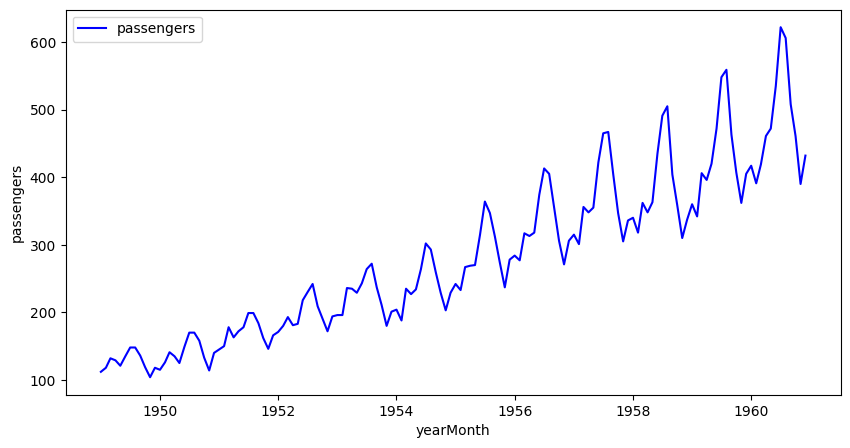

In [4]:
plt.figure(figsize=(10,5))
sns.lineplot(data=df,x=df.index,y=df.passengers, color='b',label='passengers')

## Now, lets do decomposition to see the check the trend, seasonality, irregularity.

In [5]:
from statsmodels.tsa.seasonal import STL

In [6]:
stl = STL(df['passengers'])
result = stl.fit()
seasonal, trend, resid = result.seasonal, result.trend, result.resid

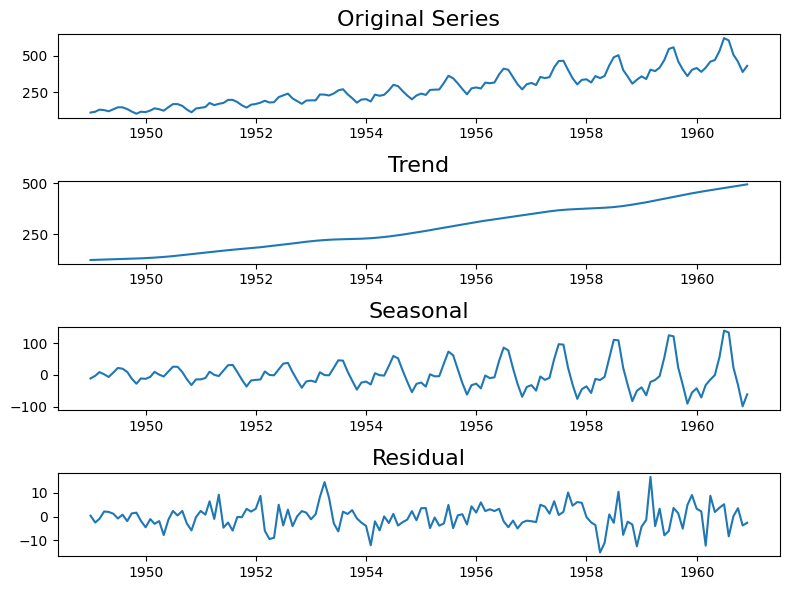

In [7]:
plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(df['passengers'])
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

### So, there is an upward trend and pure seasonality.

##Checking Stationarity.

There is 2 way:

1. Rolling mean & std method (visualization method)

2. ADFuller test:

    The null and alternative hypotheses for the ADF Test are defined as:

    **Null hypothesis**: The Time Series is non-stationary

    **Alternative hypothesis**: The Time Series is stationary

## Method 1

<Axes: xlabel='yearMonth', ylabel='passengers'>

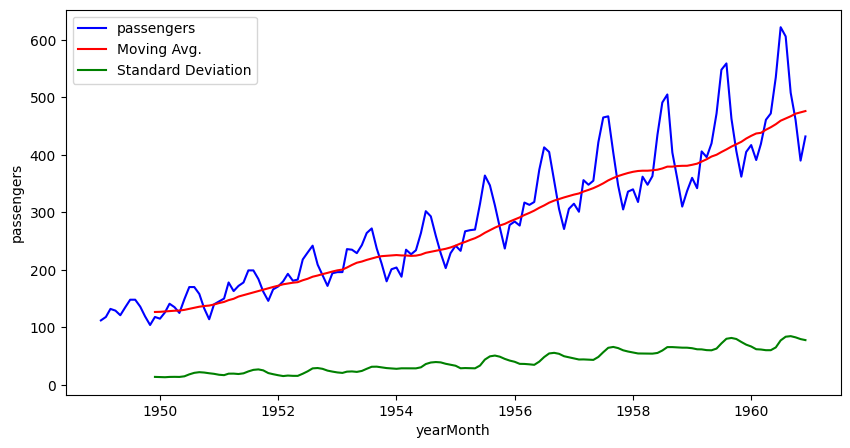

In [8]:
df['rollMean']  = df.passengers.rolling(window=12).mean()
df['rollStd']  = df.passengers.rolling(window=12).std()
plt.figure(figsize=(10,5))
sns.lineplot(data=df,x=df.index,y=df.passengers, color='b',label='passengers')
sns.lineplot(data=df,x=df.index,y=df.rollMean, color='r',label='Moving Avg.')
sns.lineplot(data=df,x=df.index,y=df.rollStd, color='g',label='Standard Deviation')

Seems, there is an upward trend. Mean is not constant.

## Method 2

In [9]:
# Creating function of adfuller for reuse
def test_stationarity(dataFrame, var):
    dataFrame['rollMean']  = dataFrame[var].rolling(window=12).mean()
    dataFrame['rollStd']  = dataFrame[var].rolling(window=12).std()

    from statsmodels.tsa.stattools import adfuller
    adfTest = adfuller(dataFrame[var],autolag='AIC')
    stats = pd.Series(adfTest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
    print(stats)

    for key, values in adfTest[4].items():
        print('criticality',key,":",values)

    plt.figure(figsize=(10,5))
    sns.lineplot(data=dataFrame,x=dataFrame.index,y=var, color='b',label=var)
    sns.lineplot(data=dataFrame,x=dataFrame.index,y='rollMean', color='r',label='Moving Avg.')
    sns.lineplot(data=dataFrame,x=dataFrame.index,y='rollStd', color='g',label='Standard Deviation')
    plt.legend()

Test Statistic                   0.815369
p-value                          0.991880
#lags used                      13.000000
number of observations used    130.000000
dtype: float64
criticality 1% : -3.4816817173418295
criticality 5% : -2.8840418343195267
criticality 10% : -2.578770059171598


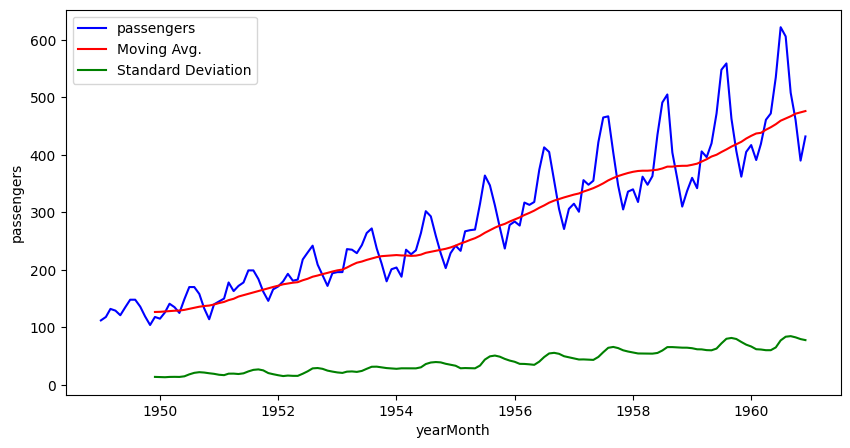

In [10]:
test_stationarity(df,'passengers')

### Observations:

From the above test, we can see that the p-value = 0.99 i.e. > 0.05 (For 95% confidence intervals) therefore, we fail to reject the null hypothesis.
Hence, we can confirm that the series is non-stationary.


---



## **Making Data Stationary**

 There are several way. Most common are:

 1. Time shift difference

 2. log transformation

 3. Taking sqrt or cube

 4. Combinations of above

## Method 1

### Differnecing

In [11]:
# indirct differencing: take .shift() then difference
air_df = df[['passengers']]
air_df['shift'] = air_df.passengers.shift()  # by default it will shift by 1
air_df['shiftDiff'] = air_df['passengers'] - air_df['shift']    # difference
air_df.head()

,passengers,shift,shiftDiff
yearMonth,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,112.0,6.0
1949-03-01,132,118.0,14.0
1949-04-01,129,132.0,-3.0
1949-05-01,121,129.0,-8.0


In [12]:
# direct difference: using .diff()
air_df['directDiff']=air_df['passengers'].diff(2)   # by default it will make difference by 2
air_df.head()

,passengers,shift,shiftDiff,directDiff
yearMonth,,,,
1949-01-01,112,NaN,NaN,NaN
1949-02-01,118,112.0,6.0,NaN
1949-03-01,132,118.0,14.0,20.0
1949-04-01,129,132.0,-3.0,11.0
1949-05-01,121,129.0,-8.0,-11.0


Again, testing stationarity

Test Statistic                  -2.833426
p-value                          0.053655
#lags used                      12.000000
number of observations used    129.000000
dtype: float64
criticality 1% : -3.482087964046026
criticality 5% : -2.8842185101614626
criticality 10% : -2.578864381347275


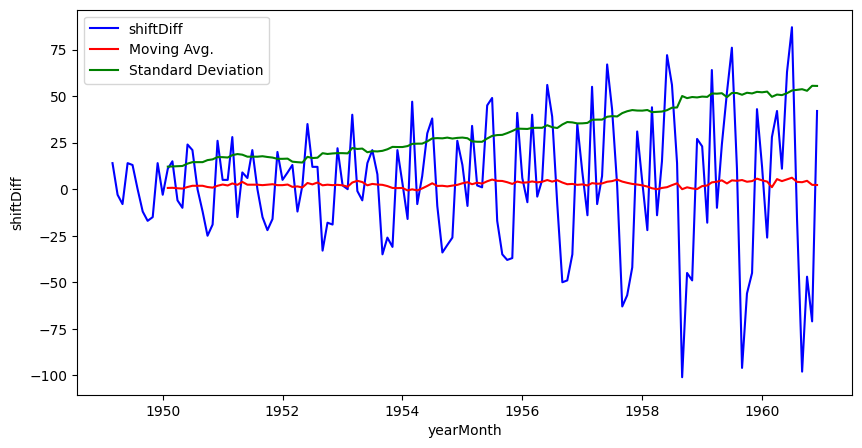

In [13]:
test_stationarity(air_df.dropna(),'shiftDiff')    #diff by 1

### Observations:

From the above test, we can see that the p-value = 0.054 i.e. > 0.05 (For 95% confidence intervals) therefore, we fail to reject the null hypothesis.
Hence, we can confirm that the series is non-stationary.

So, we need to use another method for making stationary

---



Test Statistic                  -2.961695
p-value                          0.038630
#lags used                      11.000000
number of observations used    130.000000
dtype: float64
criticality 1% : -3.4816817173418295
criticality 5% : -2.8840418343195267
criticality 10% : -2.578770059171598


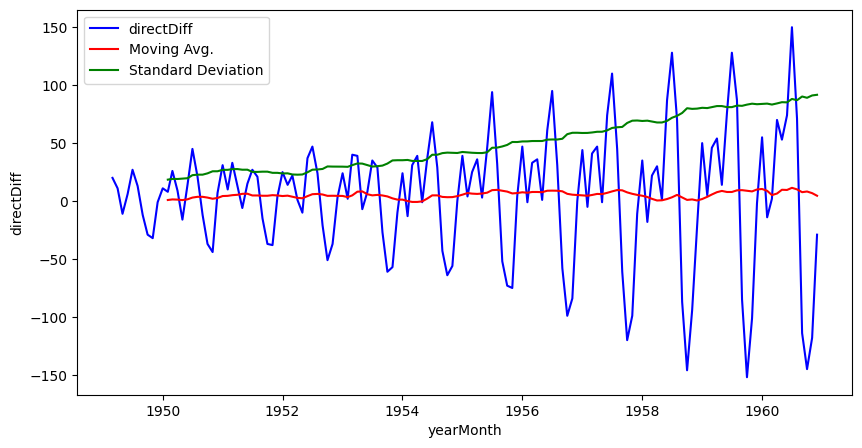

In [14]:
test_stationarity(air_df.dropna(),'directDiff')   #diff by 2

### Observations:

From the above test, we can see that the p-value = 0.03 i.e. < 0.05 (For 95% confidence intervals) therefore, we can reject the null hypothesis.
**But we can see that, the variance is not constant over time**. So we can confirm that the series is non-stationary.

Lets try others method

---



## Method 2

### Log transformation

In [15]:
log_df = df[['passengers']]
log_df['log'] = np.log(log_df['passengers'])
log_df.head()

,passengers,log
yearMonth,,
1949-01-01,112,4.718499
1949-02-01,118,4.770685
1949-03-01,132,4.882802
1949-04-01,129,4.859812
1949-05-01,121,4.795791


Again, testing stationarity

Test Statistic                  -1.717017
p-value                          0.422367
#lags used                      13.000000
number of observations used    130.000000
dtype: float64
criticality 1% : -3.4816817173418295
criticality 5% : -2.8840418343195267
criticality 10% : -2.578770059171598


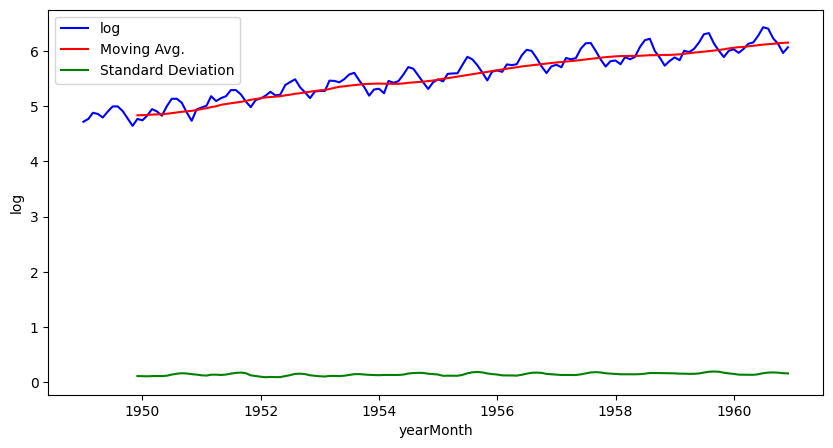

In [16]:
test_stationarity(log_df,'log')

### Observations:

From the above test, we can see that the p-value = 0.42 i.e. > 0.05 (For 95% confidence intervals) therefore, we fail to reject the null hypothesis.
Hence, we can confirm that the series is non-stationary.

So, we need to use another method for making stationary

---



## Method 3

### Taking square root (sqrt)

In [17]:
sqrt_df = df[['passengers']]
sqrt_df['sqrt'] = np.sqrt(df['passengers'])
sqrt_df.head()

,passengers,sqrt
yearMonth,,
1949-01-01,112,10.583005
1949-02-01,118,10.862780
1949-03-01,132,11.489125
1949-04-01,129,11.357817
1949-05-01,121,11.000000


Again, testing stationarity

Test Statistic                  -0.345854
p-value                          0.918754
#lags used                      13.000000
number of observations used    130.000000
dtype: float64
criticality 1% : -3.4816817173418295
criticality 5% : -2.8840418343195267
criticality 10% : -2.578770059171598


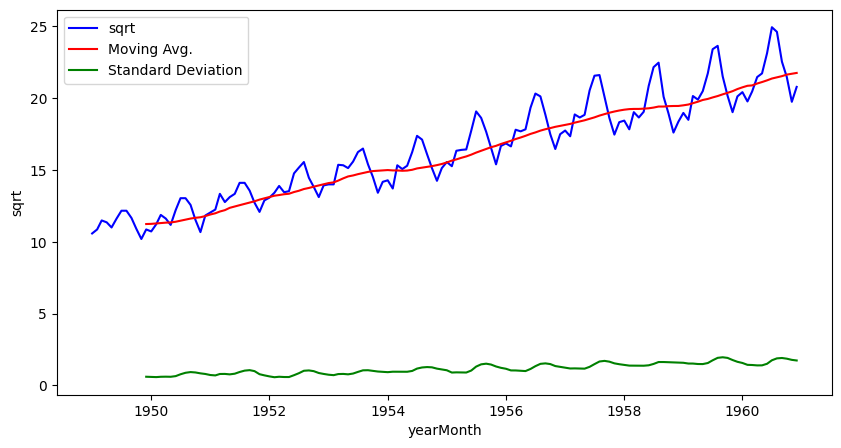

In [18]:
test_stationarity(sqrt_df,'sqrt')

### Observations:

From the above test, we can see that the p-value = 0.91 i.e. > 0.05 (For 95% confidence intervals) therefore, we fail to reject the null hypothesis.
Hence, we can confirm that the series is non-stationary.

So, we need to use another method for making stationary

---



## Method 3

### Cubic root (cbrt)

In [19]:
cbrt_df = df[['passengers']]
cbrt_df['cbrt'] = np.cbrt(cbrt_df['passengers'])
cbrt_df.head()

,passengers,cbrt
yearMonth,,
1949-01-01,112,4.820285
1949-02-01,118,4.904868
1949-03-01,132,5.091643
1949-04-01,129,5.052774
1949-05-01,121,4.946087


Test Statistic                  -0.810035
p-value                          0.816157
#lags used                      13.000000
number of observations used    130.000000
dtype: float64
criticality 1% : -3.4816817173418295
criticality 5% : -2.8840418343195267
criticality 10% : -2.578770059171598


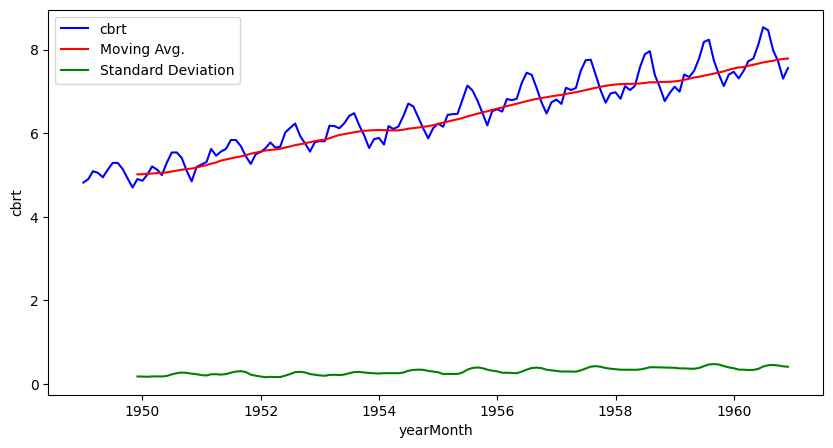

In [20]:
test_stationarity(cbrt_df,'cbrt')

## Method 4

### Combination (log+sqrt+difference)

In [21]:
log_df2 = log_df[['passengers','log']].copy(deep=True)   # log
log_df2['log_sqrt'] = np.sqrt(log_df['log'])    # sqrt of log
log_df2['logShiftDiff'] = log_df2['log_sqrt'] - log_df2['log_sqrt'].shift(2)   # difference by 2
log_df2.head()

,passengers,log,log_sqrt,logShiftDiff
yearMonth,,,,
1949-01-01,112,4.718499,2.172211,NaN
1949-02-01,118,4.770685,2.184190,NaN
1949-03-01,132,4.882802,2.209706,0.037496
1949-04-01,129,4.859812,2.204498,0.020309
1949-05-01,121,4.795791,2.189929,-0.019777


Again, testing stationarity

Test Statistic                  -3.098229
p-value                          0.026685
#lags used                      11.000000
number of observations used    130.000000
dtype: float64
criticality 1% : -3.4816817173418295
criticality 5% : -2.8840418343195267
criticality 10% : -2.578770059171598


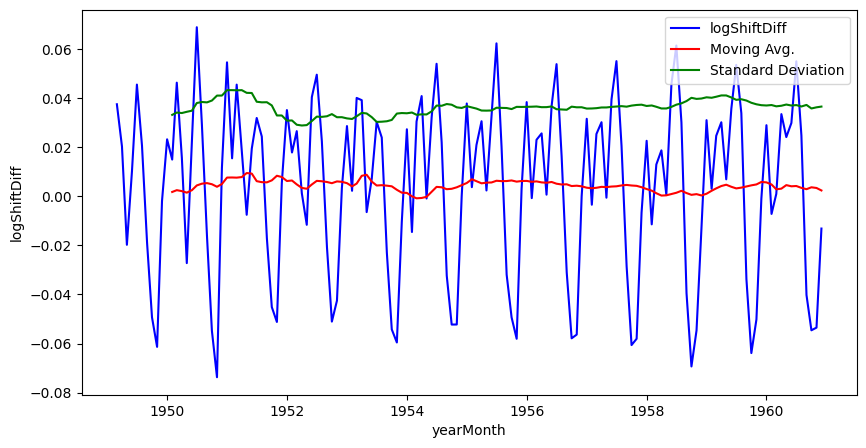

In [22]:
test_stationarity(log_df2.dropna(),'logShiftDiff')

### Observations:

From the above test, we can see that the p-value = 0.02 i.e. < 0.05 (For 95% confidence intervals) therefore, we can reject the null hypothesis.
Hence, we can confirm that the series is stationary.

Lets try others method

---



### Log+shift(2)

In [23]:
log_shift = df[['passengers']].copy(deep=True)
log_shift['log'] = np.log(log_shift['passengers'])
log_shift['logShift'] = log_shift['log'].shift(2)
log_shift['logShiftDiff'] = log_shift['log'] - log_shift['logShift']
log_shift.head()

,passengers,log,logShift,logShiftDiff
yearMonth,,,,
1949-01-01,112,4.718499,NaN,NaN
1949-02-01,118,4.770685,NaN,NaN
1949-03-01,132,4.882802,4.718499,0.164303
1949-04-01,129,4.859812,4.770685,0.089128
1949-05-01,121,4.795791,4.882802,-0.087011


Test Statistic                  -3.167907
p-value                          0.021919
#lags used                      11.000000
number of observations used    130.000000
dtype: float64
criticality 1% : -3.4816817173418295
criticality 5% : -2.8840418343195267
criticality 10% : -2.578770059171598


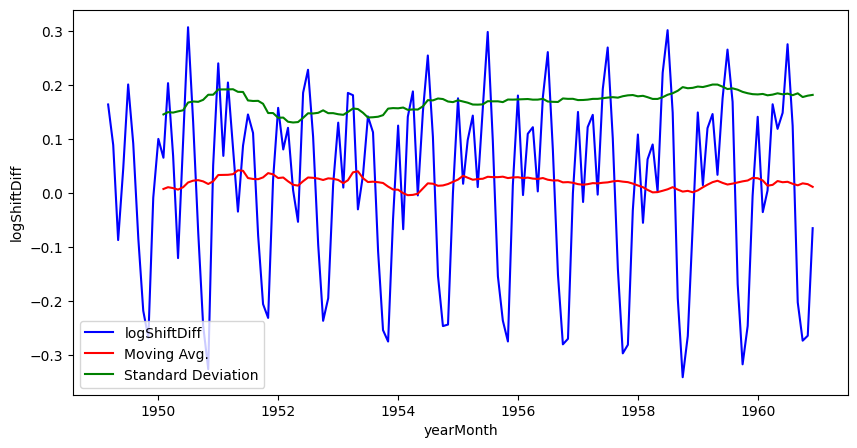

In [24]:
test_stationarity(log_shift.dropna(),'logShiftDiff')

### Observations:

From the above test, we can see that the p-value = 0.02 i.e. < 0.05 (For 95% confidence intervals) therefore, we can reject the null hypothesis.
Hence, we can confirm that the series is stationary.



---

## Creating 1st and 12th difference

In [25]:
airP = df[['passengers']].copy(deep=True)
airP['firstDiff'] = airP['passengers'].diff()
airP['Diff12'] = airP['passengers'].diff(12)
airP.head(20)

,passengers,firstDiff,Diff12
yearMonth,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,6.0,NaN
1949-03-01,132,14.0,NaN
1949-04-01,129,-3.0,NaN
1949-05-01,121,-8.0,NaN
1949-06-01,135,14.0,NaN
1949-07-01,148,13.0,NaN
1949-08-01,148,0.0,NaN
1949-09-01,136,-12.0,NaN


## **Creating Train and Test dataset**

In [26]:
train = airP[:round(len(airP)*70/100)]
len(train)

101

In [27]:
test = airP[round(len(airP)*70/100):]
len(test)

43

### **Checking ACF & PACF**

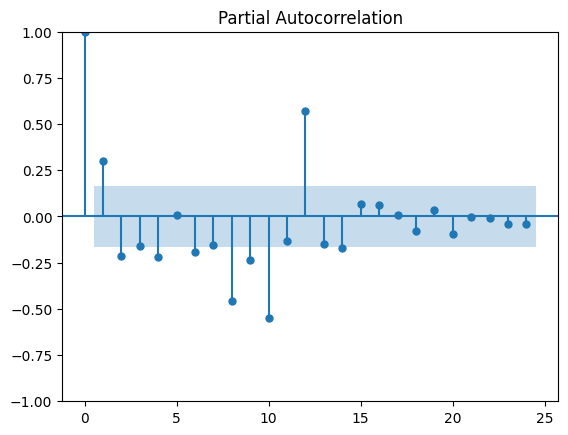

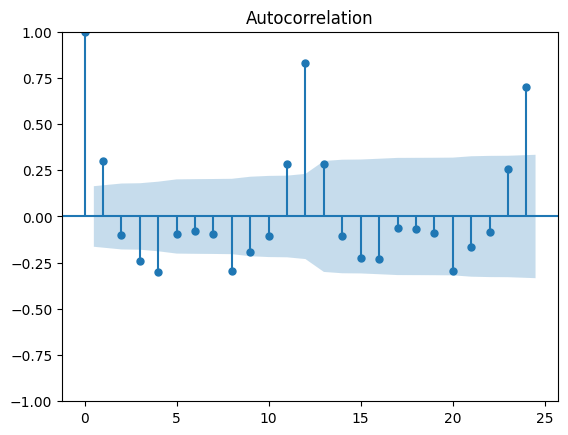

In [28]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error as mse


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_pacf(airP['firstDiff'].dropna(),lags=24);
plot_acf(airP['firstDiff'].dropna(),lags=24);

### **Creating iterative function to find best parameter**

In [29]:
import itertools
import time

In [30]:
def arima_parameter(p,d,q):
  start_time = time.time()
  a=range(0,p+1)
  b=range(0,d+1)
  c=range(0,q+1)
  pdq_combination=list(itertools.product(a,b,c))
  rmse=[]
  order1=[]
  for pdq in pdq_combination:
    try:
      model=ARIMA(train['passengers'],order=pdq).fit()
      pred=model.predict(start=test.index[0],end=test.index[-1])
      error=np.sqrt(mse(test['passengers'],pred))
      order1.append(pdq)
      rmse.append(error)
    except:
      continue
  combined = list(zip(order1, rmse))
  lowest_rmse_tuple = min(combined, key=lambda x: x[1])
  end_time = time.time()
  elapsed_time = end_time - start_time
  output = "Order: " + str(lowest_rmse_tuple[0]) + " with lowest RMSE: " + str(round(lowest_rmse_tuple[1],3))+"; Required time: " + str(round(elapsed_time,2)) + " seconds"
  return output

### **Using function**

passing p=4, d=2, q=4

In [31]:
# arima_parameter(4,2,4)

Order: (3, 2, 3) with lowest RMSE: 67.314; Required time: 29.01 seconds

p=11, d=2, q=2

Using ARIMA model

In [32]:
model = ARIMA(train['passengers'],order=(3,2,3))
model_fit1 = model.fit()
prediction = model_fit1.predict(start=test.index[0],end=test.index[-1])
airP['arimaPred'] = prediction
airP.tail()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,passengers,firstDiff,Diff12,arimaPred
yearMonth,,,,
1960-08-01,606,-16.0,47.0,475.292892
1960-09-01,508,-98.0,45.0,478.554154
1960-10-01,461,-47.0,54.0,481.824693
1960-11-01,390,-71.0,28.0,485.087466
1960-12-01,432,42.0,27.0,488.356740


<Axes: xlabel='yearMonth', ylabel='passengers'>

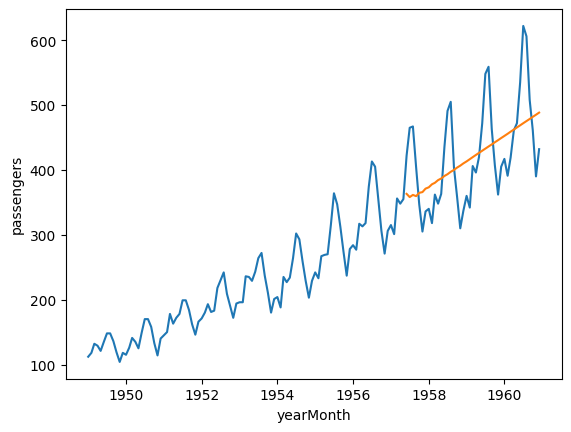

In [33]:
airP.dropna()
sns.lineplot(data=airP,x=airP.index,y='passengers')
sns.lineplot(data=airP,x=airP.index,y='arimaPred')

In [34]:
np.sqrt(mse(test['passengers'],prediction))

67.31429886798547

## Looks very bad prediction!

## So, we will use SARIMA model

In [35]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Finding seasonal ACF & PACF

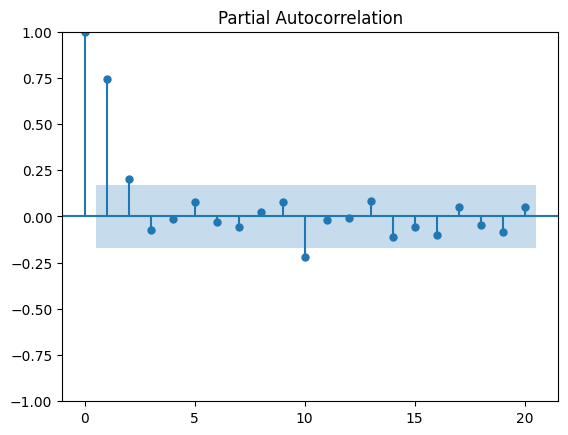

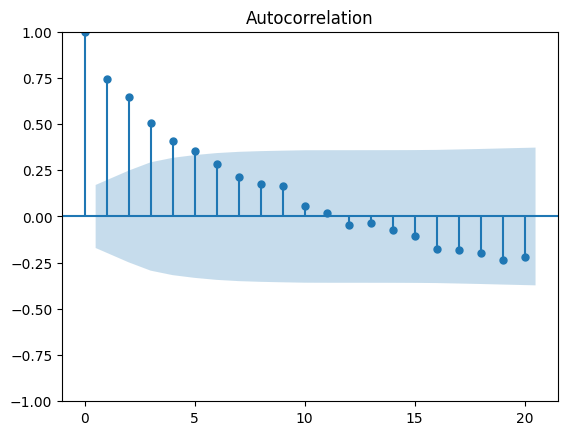

In [36]:
plot_pacf(airP['Diff12'].dropna(),lags=20);
plot_acf(airP['Diff12'].dropna(),lags=20);

**Itterative function building for SARIMA**

In [37]:
def sarima_parameter(p,d,q,P,D,Q,m):
  start_time = time.time()
  a=range(0,p+1)
  b=range(0,d+1)
  c=range(0,q+1)
  A=range(0,P+1)
  B=range(0,D+1)
  C=range(0,Q+1)
  M=[m]
  pdq_combination=list(itertools.product(a,b,c,A,B,C,M))
  rmse=[]
  order1=[]
  for pdq in pdq_combination:
    try:
      order = pdq[:3]
      seasonal_order = pdq[3:]
      model=SARIMAX(train['passengers'],order=order,seasonal_order=seasonal_order).fit()
      pred=model.predict(start=test.index[0],end=test.index[-1])
      error=np.sqrt(mse(test['passengers'],pred))
      order1.append(pdq)
      rmse.append(error)
    except:
      continue
  combined = list(zip(order1, rmse))
  lowest_rmse_tuple = min(combined, key=lambda x: x[1])
  end_time = time.time()
  elapsed_time = end_time - start_time
  output = "Order: " + str(lowest_rmse_tuple[0]) + " with lowest RMSE: " + str(round(lowest_rmse_tuple[1],3))+"; Required time: " + str(round(elapsed_time,2)) + " seconds"
  return output

In [38]:
# sarima_parameter(2,1,1,2,1,4,12)

Order: (0, 0, 0, 2, 1, 4, 12) with lowest RMSE: 16.05; Required time: 879.4 seconds

In [39]:
model = SARIMAX(train['passengers'],order=(0,0,0),seasonal_order=(2,1,4,12))
model_fit = model.fit()
prediction = model_fit.predict(start=test.index[0],end=test.index[-1])
airP['sarimaxPred'] = prediction

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: xlabel='yearMonth', ylabel='passengers'>

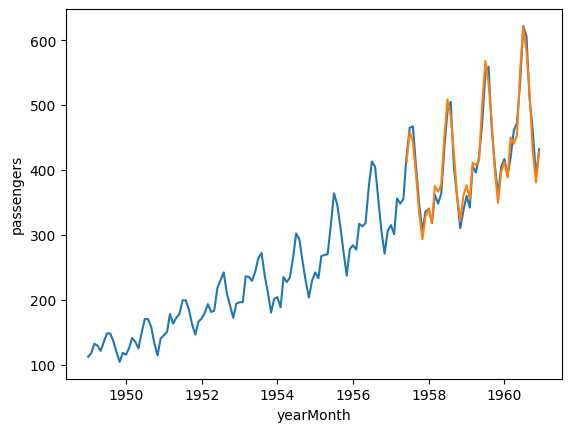

In [40]:
airP.dropna()
sns.lineplot(data=airP,x=airP.index,y='passengers')
sns.lineplot(data=airP,x=airP.index,y='sarimaxPred')
# sns.lineplot(data=airP,x=airP.index,y='arimaPred')

In [41]:
np.sqrt(mse(test['passengers'],prediction))

16.05012547104541

This model works well.

Creating new dataset for future forecast

In [42]:
futureDate = pd.DataFrame(pd.date_range(start='1961-01-01', end='1962-12-01',freq='MS'),columns=['Dates'])
futureDate.set_index('Dates',inplace=True)
futureDate.head()

""
Dates
1961-01-01
1961-02-01
1961-03-01
1961-04-01
1961-05-01


In [43]:
model = SARIMAX(train['passengers'],order=(0,0,0),seasonal_order=(2,1,4,12))
model_fit = model.fit()
model_fit.predict(start=futureDate.index[0],end=futureDate.index[-1])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1961-01-01    445.384952
1961-02-01    421.709433
1961-03-01    485.948001
1961-04-01    472.863388
1961-05-01    485.810182
1961-06-01    599.069731
1961-07-01    673.587125
1961-08-01    629.183638
1961-09-01    558.722969
1961-10-01    459.704999
1961-11-01    407.496634
1961-12-01    459.787200
1962-01-01    477.496405
1962-02-01    452.237206
1962-03-01    520.888871
1962-04-01    503.224301
1962-05-01    519.770645
1962-06-01    644.682793
1962-07-01    722.326841
1962-08-01    673.623455
1962-09-01    597.855733
1962-10-01    488.028206
1962-11-01    434.943401
1962-12-01    488.411047
Freq: MS, Name: predicted_mean, dtype: float64

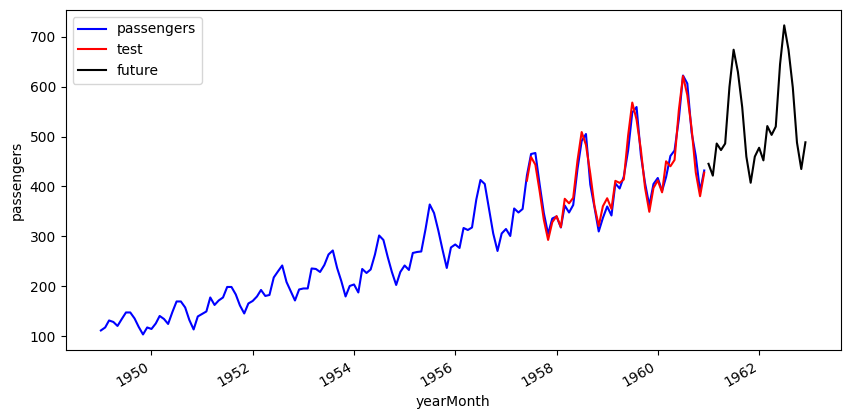

In [44]:
airP.dropna()
plt.figure(figsize=(10,5))
sns.lineplot(data=airP,x=airP.index,y='passengers',color='b',label='passengers')
sns.lineplot(data=airP,x=airP.index,y='sarimaxPred',color='r',label='test')
model_fit.predict(start=futureDate.index[0],end=futureDate.index[-1]).plot(color='black', label='future')
plt.legend()

## The future also predicted well!